### DS Academy challenge
# Cars Price Prediction
#### Piotr Baryczkowski

## Exploratory data analysis

Firstly we will categorize data types of attributes from Otomoto dataset, to correctly apply statistical measurements and conclude certain assumptions about it. In the next step we are going to analyse the distributions of attributes, look for errors and missing values. In the last step we will try to understand how certain attributes affect target price of vehicle e.g. is newer car more expensive than a slightly older car (vehicle_year attribute)?

#### Python libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

#### Dataset overview

In [2]:
# Load dataset
df = pd.read_csv(f"{os.getcwd()}/dataset/otomoto_price_prediction_data.csv")
# Display first 5 rows from dataset
df.head()

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price
0,audi,a6,2013,153817.0,1984.0,180.0,automatic,petrol,0,0,69900.0
1,skoda,fabia,2004,115000.0,1390.0,75.0,manual,petrol,0,1,8299.0
2,chevrolet,camaro,2012,299000.0,3600.0,323.0,automatic,petrol,0,1,54500.0
3,bmw,seria-3,2013,155000.0,1995.0,163.0,automatic,diesel,0,0,62000.0
4,renault,talisman,2017,167000.0,1600.0,130.0,automatic,diesel,0,1,52999.0


In [3]:
NUM_RECORDS = df.shape[0] # used later to show how many records was dropped in preprocessing
df.shape

(206207, 11)

Dataset consists of 206207 samples, which are described with 10 attributes and the target price.

#### Attribute types

__Categorical attributes:__

- Nominal
  - make
  - model
  - gearbox
  - fuel_type

__Numerical attributes:__

- Discrete
  - damaged
  - is_business

- Interval
  - vehicle_year

- Continuous
  - mileage
  - engine_capacity
  - engine_power

#### Target type

The target price is categorized as a continuous type.

#### Looking for missing values and errors

Firstly we will make sure if there are some missing values in our dataset.

In [4]:
df.isna().sum()

make                  0
model                 0
vehicle_year          0
mileage            1354
engine_capacity    2178
engine_power       1579
gearbox            1365
fuel_type             0
damaged               0
is_business           0
target_price          0
dtype: int64

As we can see there is some lack of data in mileage, engine_capacity, engine_power and gearbox attribute. We will deal with this problem later in data preprocessing phase.

Now we will look for some errors.

In [5]:
df.describe()

,vehicle_year,mileage,engine_capacity,engine_power,damaged,is_business,target_price
count,206207.000000,2.048530e+05,204029.000000,204628.000000,206207.000000,206207.000000,2.062070e+05
mean,2012.313855,6.656787e+05,1865.096922,151.300301,0.038059,0.600038,6.273519e+04
std,6.453940,2.040768e+08,708.559717,76.915073,0.191339,0.489891,8.604596e+04
min,1917.000000,1.000000e+00,400.000000,1.000000,0.000000,0.000000,6.000000e+02
25%,2008.000000,4.500000e+04,1461.000000,105.000000,0.000000,0.000000,1.799900e+04
50%,2013.000000,1.378500e+05,1797.000000,136.000000,0.000000,1.000000,3.590000e+04
75%,2017.000000,1.990000e+05,1997.000000,170.000000,0.000000,1.000000,7.490000e+04
max,2021.000000,9.060612e+10,8400.000000,1500.000000,1.000000,1.000000,5.250000e+06


In the table above, we can find some interesting information e.g. minimal engine_power is 1 or maximum mileage which is 90 billions. To build the model correctly we will have to clear our data from that noise.

### Statistics

#### Target price distribution

1. The distribution is left skewed and of high variance
2. 75% of cars cost less than 74900 PLN
3. Maximum value of vehicle is 5250000 PLN, minimum is equal 600 PLN

I reckon, that these single cars with high prices can affect our model, so we have to consider that later.

In [6]:
df.target_price.describe()

count    2.062070e+05
mean     6.273519e+04
std      8.604596e+04
min      6.000000e+02
25%      1.799900e+04
50%      3.590000e+04
75%      7.490000e+04
max      5.250000e+06
Name: target_price, dtype: float64

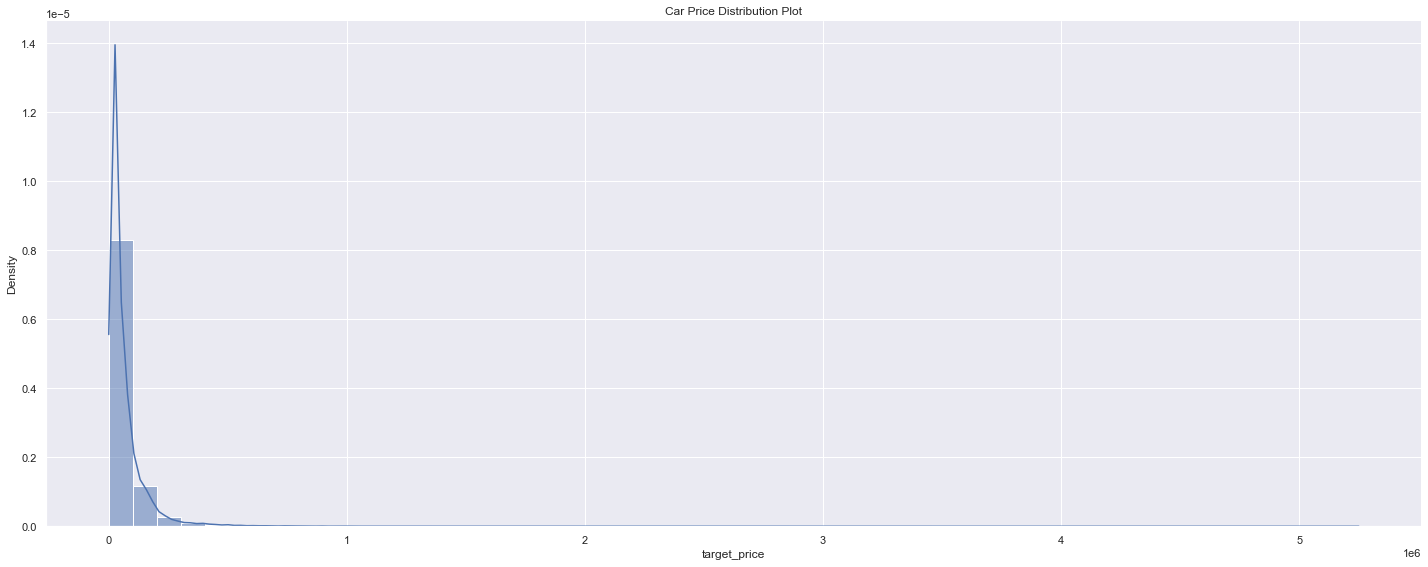

In [7]:
sns.set(rc= {"figure.figsize": (20,8)})

IQR = df.target_price.quantile(0.75) - df.target_price.quantile(0.25)
h = 2 * IQR * len(df.target_price)**(-1/3)
bins = (np.max(df.target_price) - np.min(df.target_price)) // h

sns.displot(data=df.target_price, stat="density", kde=True,
            bins=int(np.sqrt(bins)), height=8, aspect=20 / 8).set(title='Car Price Distribution Plot');

#### Make

Make attribute consists of 108 unique values. The most popular make is Volkswagen.

In [8]:
df.make.describe()

count         206207
unique           108
top       volkswagen
freq           18392
Name: make, dtype: object

In [9]:
makes_counted = df.make.value_counts()
top_makes = makes_counted.head(15)
print(f"Most popular makes:\n{top_makes}")

Most popular makes:
volkswagen       18392
opel             16652
ford             16437
bmw              15783
audi             15349
mercedes-benz    11613
toyota           10839
renault          10687
skoda            10586
peugeot           8255
citroen           7239
hyundai           6145
kia               6119
volvo             5781
nissan            5083
Name: make, dtype: int64


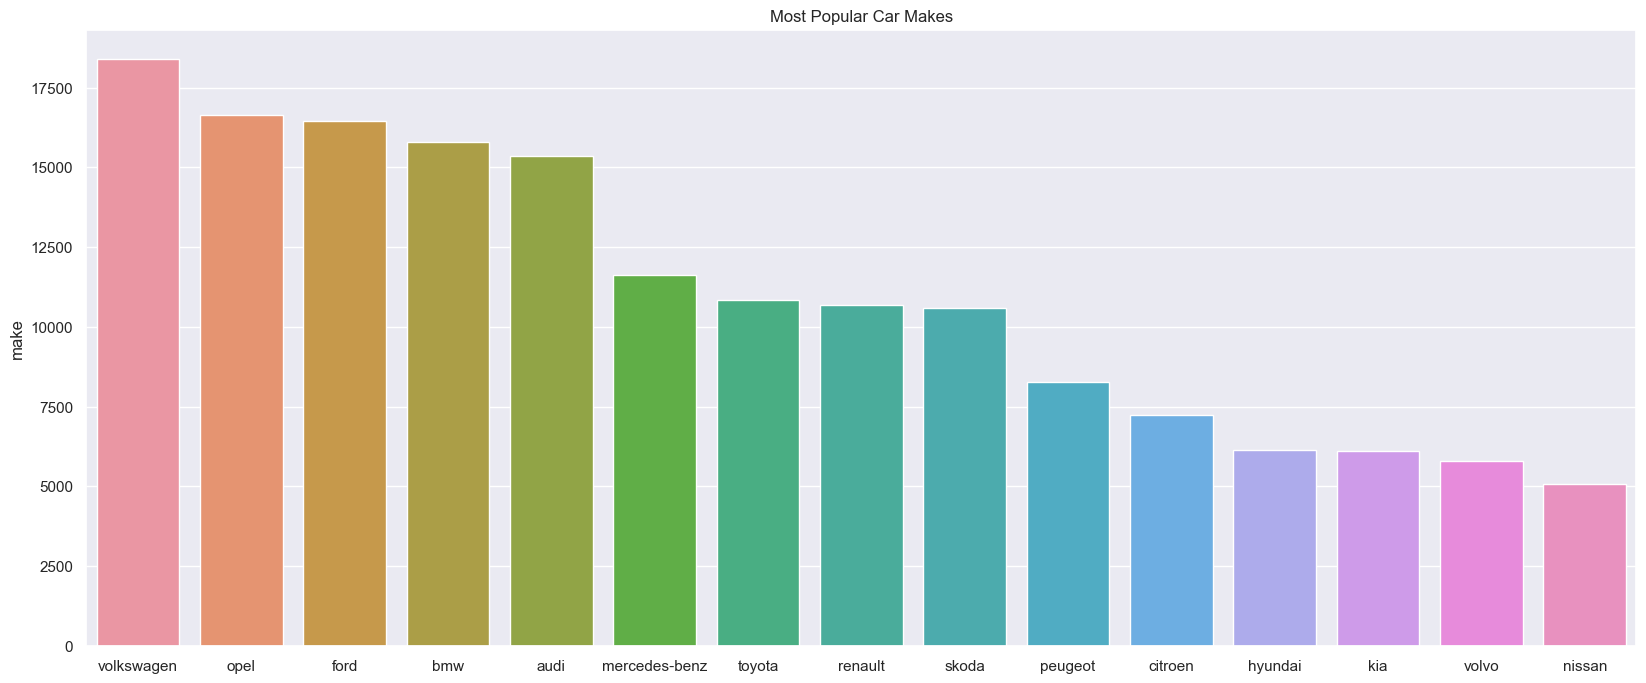

In [10]:
sns.barplot(x=top_makes.index, y=top_makes).set(title='Most Popular Car Makes');

In [11]:
rare_makes = makes_counted.tail(15)
print(f"Rarest makes:\n{rare_makes}")

Rarest makes:
radical        2
gaz            2
autobianchi    2
vanderhall     2
brilliance     2
piaggio        1
tarpan         1
talbot         1
bac            1
scion          1
vauxhall       1
grecav         1
shuanghuan     1
moskwicz       1
zastawa        1
Name: make, dtype: int64


#### Model

In our dataset we can find 1165 unique car models. Astra is the most popular vehicle model in our dataset.

In [12]:
df.model.describe()

count     206207
unique      1165
top        astra
freq        5573
Name: model, dtype: object

Now we will look at the most popular vehicle models for our top_makes.

In [13]:
make_most_popular_model = df.groupby('make').agg({'model': lambda x: x.mode().max()}).reset_index()
top_models = make_most_popular_model.loc[make_most_popular_model['make'].isin(top_makes.index)]
top_models

,make,model
6,audi,a4
11,bmw,seria-3
19,citroen,c3
31,ford,focus
37,hyundai,i30
43,kia,ceed
56,mercedes-benz,klasa-e
63,nissan,qashqai
66,opel,astra
68,peugeot,308


#### Gearbox and fuel type

In our dataset we can find 10 unique gearboxes and 7 unique fuel types. The most popular gearbox is manual and the most popular fuel type is petrol.

In [14]:
df[['gearbox', 'fuel_type']].describe()

,gearbox,fuel_type
count,204842,206207
unique,10,7
top,manual,petrol
freq,133598,103723


As we can see below manual and automatic gearbox make up 97.3% of our dataset. The rest of vehicles mainly have dual-clutch or cvt gearboxes. There are few cars with semi-automatic, automatic-stepless, automatic-sequential, automatic-manual or automatic-stepless-sequential gearbox. Rarest gearbox, that we can find in our dataset is manual-sequential used in F1 cars.

In [15]:
top_gearbox = df.gearbox.value_counts()
print(f"Most popular gearbox:\n{top_gearbox}")

Most popular gearbox:
manual                           133598
automatic                         67034
dual-clutch                        2331
cvt                                1742
semi-automatic                       83
automatic-stepless                   31
automatic-sequential                  9
automated-manual                      7
automatic-stepless-sequential         6
manual-sequential                     1
Name: gearbox, dtype: int64


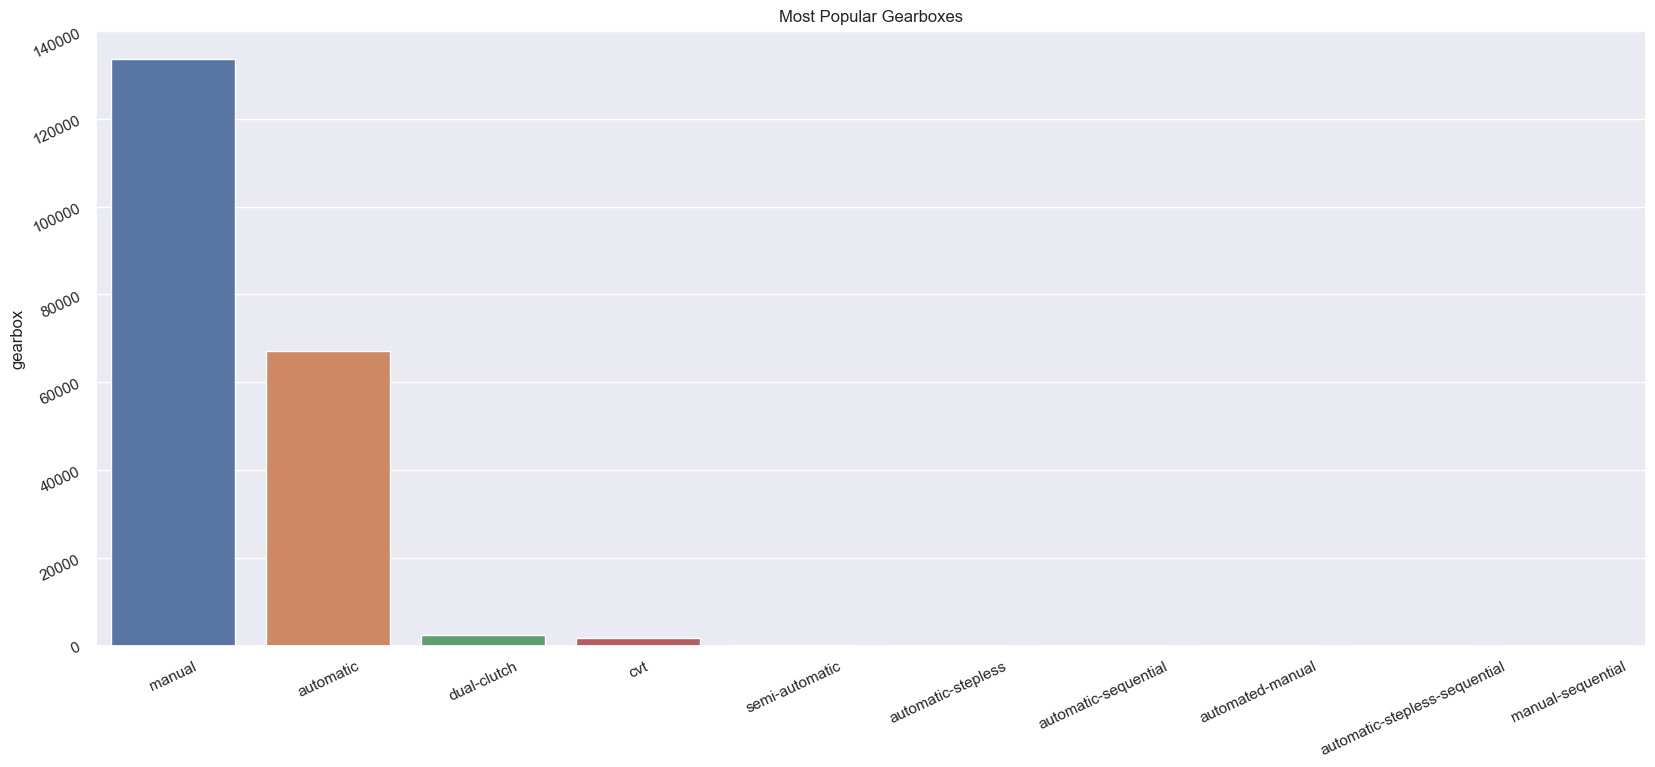

In [16]:
plt.tick_params(rotation=25)
sns.barplot(x=top_gearbox.index, y=top_gearbox).set(title='Most Popular Gearboxes');

The most popular fuel types are petrol and diesel. More than 6000 cars are electric and hybrid. Almost 9000 cars have petrol-lpg fuel type. The least popular fuel types are petrol-cng and etanol.

In [17]:
top_fuel = df.fuel_type.value_counts()
print(f"Most popular fuel type:\n{top_fuel}")

Most popular fuel type:
petrol        103723
diesel         87669
petrol-lpg      8655
hybrid          5106
electric         994
petrol-cng        59
etanol             1
Name: fuel_type, dtype: int64


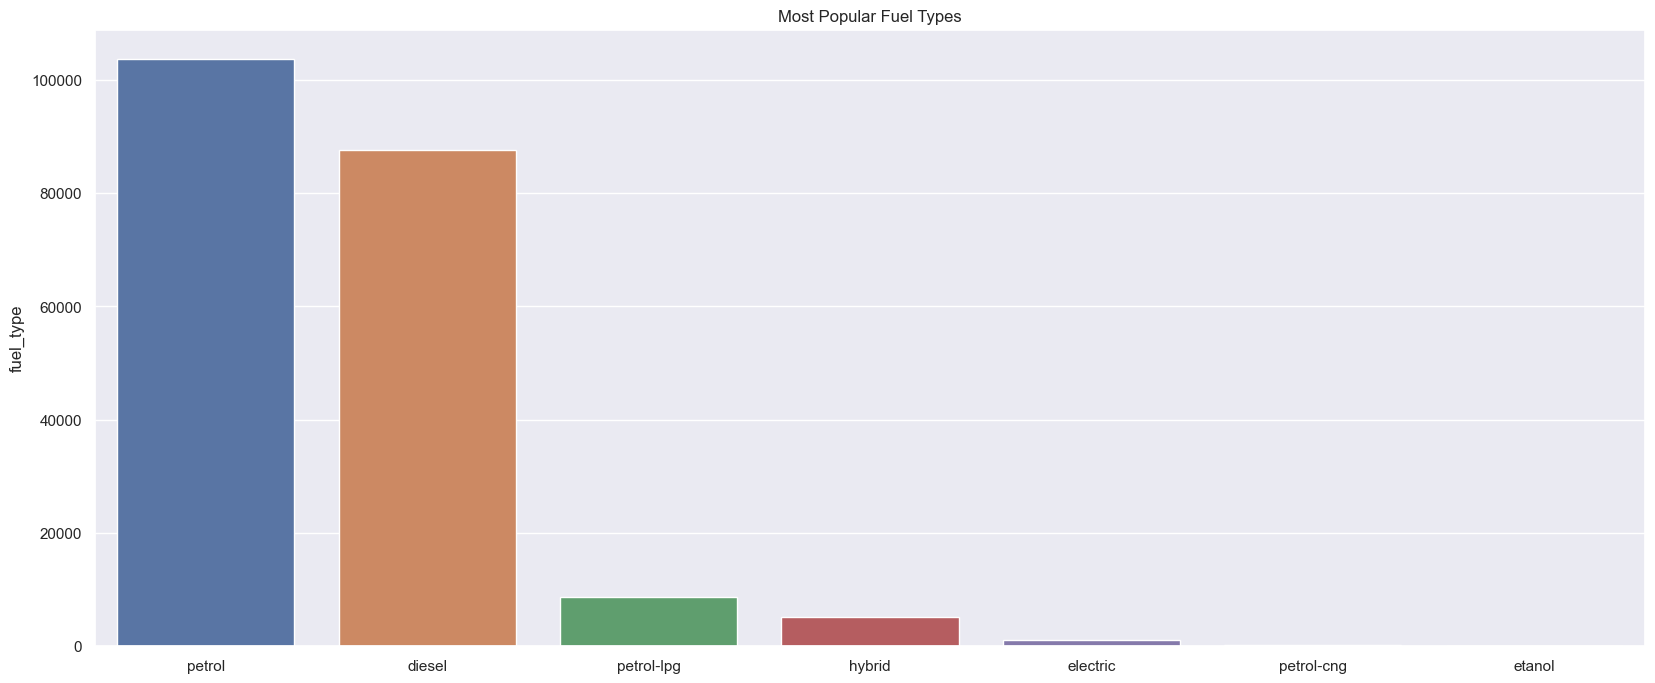

In [18]:
sns.barplot(x=top_fuel.index, y=top_fuel).set(title='Most Popular Fuel Types');

#### Vehicle year

The histogram of vehicle production year is right skewed. The oldest car is from 1917 and the newest is from 2021. As we can observe 75% of cars were produced after 2008, half of them after 2013 and 25% of them after 2017.

In [19]:
df.vehicle_year.describe()

count    206207.000000
mean       2012.313855
std           6.453940
min        1917.000000
25%        2008.000000
50%        2013.000000
75%        2017.000000
max        2021.000000
Name: vehicle_year, dtype: float64

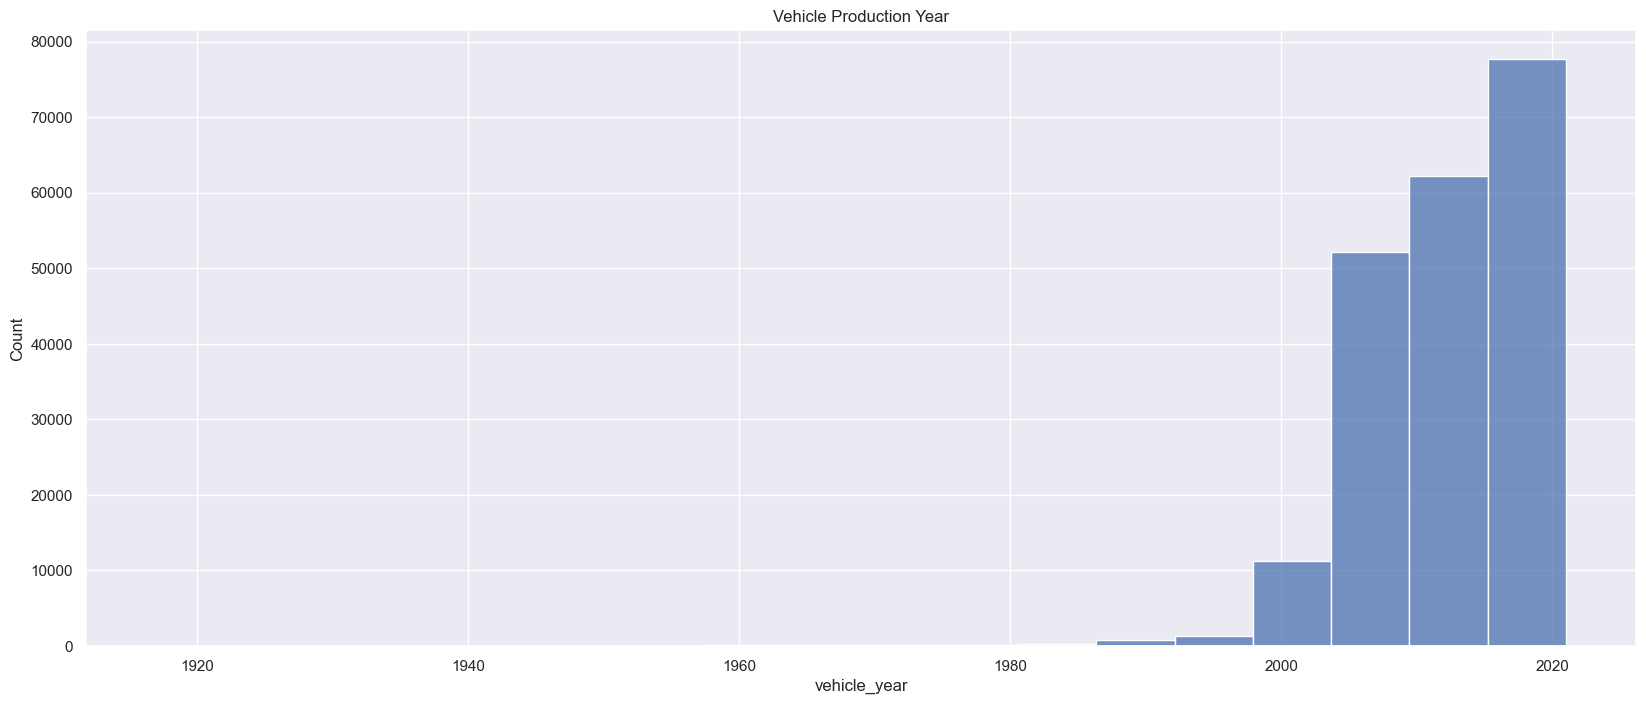

In [20]:
sns.histplot(data=df.vehicle_year, bins=18).set(title='Vehicle Production Year');

#### Damaged and business cars

96% of cars in our dataset are not damaged. 60% of sellers are business sellers rest of them are individual sellers.

In [21]:
is_damaged = df.damaged.copy()
is_damaged = is_damaged.map({0: 'No', 1: 'Yes'})
print(f"Not damaged: {(is_damaged.value_counts()[0] / len(is_damaged) * 100):.2f}%\n"
      f"Damaged: {(is_damaged.value_counts()[1] / len(is_damaged) * 100):.2f}%\n")
print(f"Is car damaged:\n{is_damaged.value_counts()}")

Not damaged: 96.19%
Damaged: 3.81%

Is car damaged:
No     198359
Yes      7848
Name: damaged, dtype: int64


In [22]:
seller_type = df.is_business.copy()
seller_type = seller_type.map({0:'individual', 1:'business'})
print(f"Business seller: {(seller_type.value_counts()[0] / len(seller_type) * 100):.2f}%\n"
      f"Individual seller: {(seller_type.value_counts()[1] / len(seller_type) * 100):.2f}%\n")
print(f"Type of sellers:\n{seller_type.value_counts()}")

Business seller: 60.00%
Individual seller: 40.00%

Type of sellers:
business      123732
individual     82475
Name: is_business, dtype: int64


## Data preprocessing

### Dealing with missing data

As I mentioned before, we are going to deal with the missing data.

In [23]:
df[df.isnull().any(axis=1)].head(5)

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price
143,mercedes-benz,gle,2020,NaN,2925.0,272.0,automatic,diesel,0,1,355400.0
243,audi,a5,2008,217000.0,NaN,NaN,NaN,diesel,0,0,35999.0
325,volkswagen,caddy,2020,NaN,1968.0,150.0,manual,diesel,0,1,129900.0
353,mini,clubman,2018,25500.0,NaN,NaN,NaN,petrol,0,0,84900.0
363,seat,leon,2008,128933.0,1600.0,102.0,NaN,petrol,0,0,17200.0


We are going to fill missing data in attributes (mileage, engine_capacity and engine_power) with the median values.


In [24]:
import warnings
warnings.filterwarnings('ignore')

df.fillna(df.median(), inplace=True)

There is still some missing data in gearbox attribute. We are going to fill it with values based on vehicle model. If there will still be some missing data, we are going to fill it with the most popular gearbox.

In [25]:
df[df.isnull().any(axis=1)]

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price
243,audi,a5,2008,217000.0,1797.0,136.0,NaN,diesel,0,0,35999.0
353,mini,clubman,2018,25500.0,1797.0,136.0,NaN,petrol,0,0,84900.0
363,seat,leon,2008,128933.0,1600.0,102.0,NaN,petrol,0,0,17200.0
413,opel,zafira,2009,189000.0,1800.0,140.0,NaN,petrol,0,1,18500.0
473,mazda,6,2014,62000.0,1797.0,136.0,NaN,petrol,0,0,45500.0
...,...,...,...,...,...,...,...,...,...,...,...
205664,bmw,seria-3,2004,215111.0,1797.0,136.0,NaN,petrol,0,0,8700.0
205772,kia,ceed,2018,86450.0,1400.0,100.0,NaN,petrol,0,1,49190.0
205797,opel,insignia,2009,183500.0,1999.0,220.0,NaN,petrol,0,0,37000.0
206040,ford,fusion,2006,257000.0,1400.0,136.0,NaN,diesel,1,1,3900.0


In [26]:
def get_gearbox_type(row):
    mode = df[(df.make == row['make']) & (df.model == row['model'])]['gearbox'].mode()
    if mode.empty:
        return np.nan
    return mode[0]

In [27]:
df.gearbox = df.apply(lambda row: get_gearbox_type(row) if row['gearbox'] == np.nan else row['gearbox'], axis=1)

In [28]:
df[df.isnull().any(axis=1)]

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price
243,audi,a5,2008,217000.0,1797.0,136.0,NaN,diesel,0,0,35999.0
353,mini,clubman,2018,25500.0,1797.0,136.0,NaN,petrol,0,0,84900.0
363,seat,leon,2008,128933.0,1600.0,102.0,NaN,petrol,0,0,17200.0
413,opel,zafira,2009,189000.0,1800.0,140.0,NaN,petrol,0,1,18500.0
473,mazda,6,2014,62000.0,1797.0,136.0,NaN,petrol,0,0,45500.0
...,...,...,...,...,...,...,...,...,...,...,...
205664,bmw,seria-3,2004,215111.0,1797.0,136.0,NaN,petrol,0,0,8700.0
205772,kia,ceed,2018,86450.0,1400.0,100.0,NaN,petrol,0,1,49190.0
205797,opel,insignia,2009,183500.0,1999.0,220.0,NaN,petrol,0,0,37000.0
206040,ford,fusion,2006,257000.0,1400.0,136.0,NaN,diesel,1,1,3900.0


In [29]:
# Fill the rest with mode
df['gearbox'].fillna(df['gearbox'].mode().max(), inplace=True)

In [30]:
df[df.isnull().any(axis=1)]

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price


### Dealing with unreliable data

In my car I have a seven-digit counter, where last digit is for hundreds of meters, so I assume, that maximum reliable mileage is 999999. An average car user travels up to 1000 miles a month, so it gives 12000 miles a year. We can find lots of company cats on the market so reliable mileage per year will be higher. In my opinion 65000 is an upper limit for this attribute.

Sources:
[https://heycar.co.uk/guides/what-is-high-mileage](https://heycar.co.uk/guides/what-is-high-mileage)
[How much horsepower constitutes as enough for a car?](https://www.quora.com/How-much-horsepower-constitutes-as-enough-for-a-car)
[https://carbiketech.com/engine-capacity-cc/](https://carbiketech.com/engine-capacity-cc/)

In [31]:
import datetime
current_year = datetime.datetime.now().year

MAXIMUM_RELIABLE_MILEAGE = 10**6 - 1
MAXIMUM_RELIABLE_MILEAGE_PER_YEAR = 65 * 10**3
MINIMUM_HORSEPOWER = 48 # The VW Rabbit MK1 Diesels of the late 1970’s had a whopping 48HP
MAXIMUM_ENGINE_CAPACITY = 5000

df.drop(df[df.mileage > MAXIMUM_RELIABLE_MILEAGE].index, inplace=True)
df.drop(df[df.mileage / (current_year - df.vehicle_year + 1) > MAXIMUM_RELIABLE_MILEAGE_PER_YEAR].index, inplace=True)
df.drop(df[df.engine_capacity > MAXIMUM_ENGINE_CAPACITY].index, inplace=True)
df.drop(df[df.engine_power < MINIMUM_HORSEPOWER].index, inplace=True)

print(f"Dropped {NUM_RECORDS - df.shape[0]} records.")

Dropped 2296 records.


### Dealing with categorical attributes

Our dataset consists of both numeric and categorical attributes. We have to transform our categorical attributes into numeric values, because our model need to understand them as inputs. That is why we are going to use regular label encoding to transform the categorical attributes.

In [32]:
df.make = df.make.astype('category')
df.make = df.make.cat.codes

df.model = df.model.astype('category')
df.model = df.model.cat.codes

In [33]:
GEARBOX_MAP = {'automatic': 0, 'cvt': 1, 'automatic-stepless': 2, 'automatic-sequential': 3,
               'automatic-stepless-sequential': 4, 'semi-automatic': 5, 'manual-sequential': 6,
               'automated-manual': 7, 'dual-clutch': 8, 'manual': 9}

FUEL_TYPE_MAP = {'diesel': 0, 'petrol': 1, 'petrol-lpg': 2,
                 'petrol-cng': 3, 'hybrid': 4, 'electric': 5}

df.gearbox = df.gearbox.map(GEARBOX_MAP)
df.fuel_type = df.fuel_type.map(FUEL_TYPE_MAP)

In [34]:
df.head(5)

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price
0,6,162,2013,153817.0,1984.0,180.0,0,1,0,0,69900.0
1,77,420,2004,115000.0,1390.0,75.0,9,1,0,1,8299.0
2,14,269,2012,299000.0,3600.0,323.0,0,1,0,1,54500.0
3,10,844,2013,155000.0,1995.0,163.0,0,0,0,0,62000.0
4,69,919,2017,167000.0,1600.0,130.0,0,0,0,1,52999.0


Now that our dataset is over the preprocessing phase, we are ready to create our models.

## Building model

We will start with splitting our dataset into variables and targets. Then, we will split data into training and test sets.

In [35]:
from sklearn.model_selection import train_test_split

x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In this challenge we will try two different models:

1. Decision Tree Regressor
2. Random Forest Regressor

In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Metrics

Metrics are necessary to compare and later choose our final regression model. In my opinion using more than one metrics paints bigger picture of how our model is performing. For this challenge I chose 3 metrics:

- Mean Absolute Error (MAE) - takes it easy on our model compared to RMSE.
- Root Mean Square Error (RMSE) - punishes our model when it makes big mistakes.
- Coefficient Of Determination (R2) - tells us what part of data it "explains".

The goal for us is to create and pick model with the lowest MAE and RMSE and the highest R2.

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def show_metrics(true: np.array, pred: np.array) -> None:
    print(f"MAE: {mean_absolute_error(true, pred):.4f}\n"
          f"RMSE: {np.sqrt(mean_squared_error(true, pred)):.4f}\n"
          f"R2: {r2_score(true, pred):.4f}")

def plot_compare_true_pred(true: np.array, pred:np.array) -> None:
    df = pd.DataFrame({'true_values': true, 'predicted_values': pred})
    sns.scatterplot(data=df).set(title='Predicted values vs. True values')


### Decision Tree Regressor

Our MAE is 9336 PLN and our RMSE is 27724.59 PLN which is almost 3 times higher. This means, that our model did not perform very well when it comes to expensive vehicles. On the other hand, R2 score is quiet good (it "explains" 87.98% of our data).

In [76]:
dt_regressor = DecisionTreeRegressor(max_depth=100, random_state=0)
dt_regressor.fit(x_train, y_train)
y_pred = dt_regressor.predict(x_test)

show_metrics(y_test, y_pred)

MAE: 9336.0172
RMSE: 27724.5930
R2: 0.8798


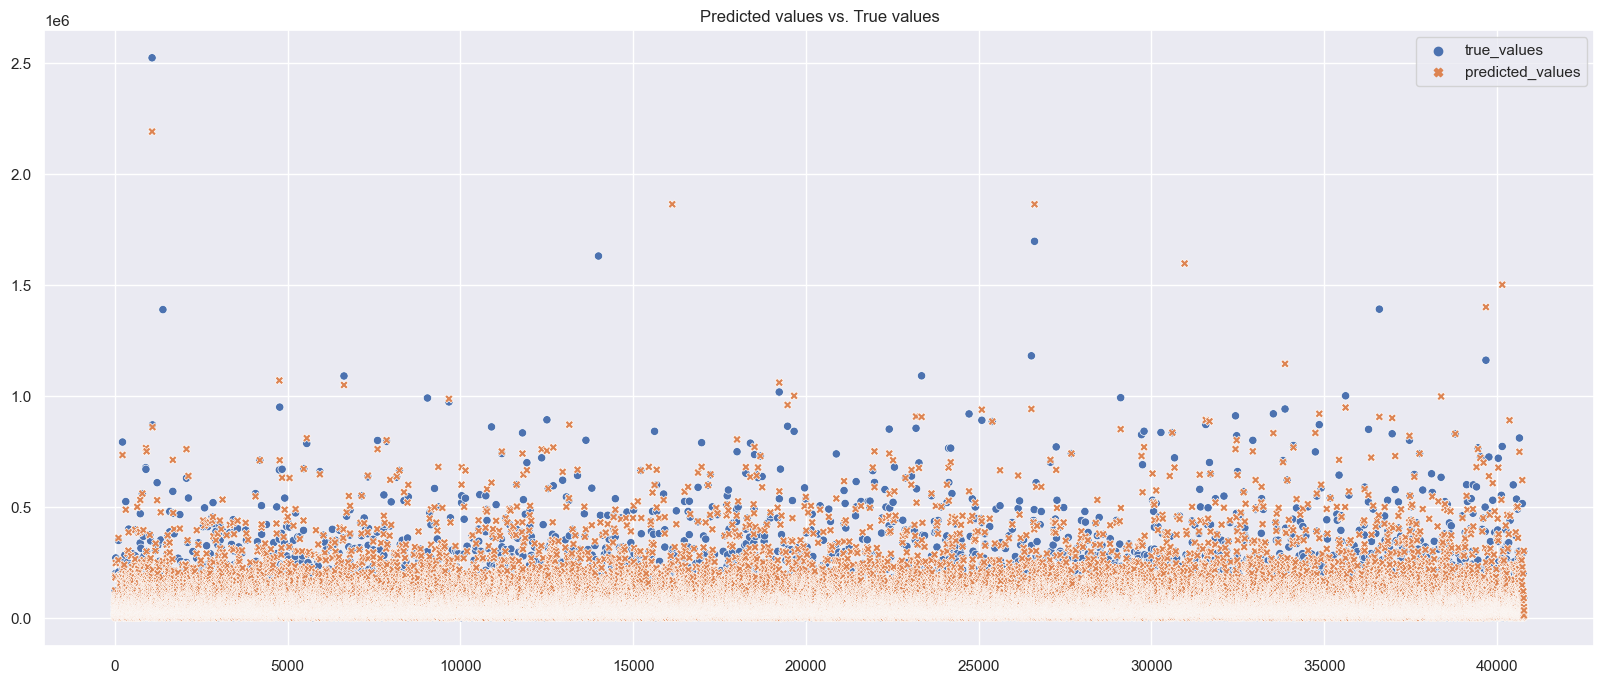

In [77]:
plot_compare_true_pred(y_test, y_pred)

### Random Forest Regressor

As we excepted, Random Forest Regressor preformed better than Decision Tree Regressor (in case of metrics). MAE score is 7491.34 PLN and RMSE is 22588.97 PLN. R2 score is also increased to 92%.

In [53]:
rf_regressor = RandomForestRegressor(max_depth=50, n_estimators=100, random_state=0)
rf_regressor.fit(x_train, y_train)
y_pred = rf_regressor.predict(x_test)

show_metrics(y_test, y_pred)

MAE: 7491.3453
RMSE: 22588.9692
R2: 0.9202


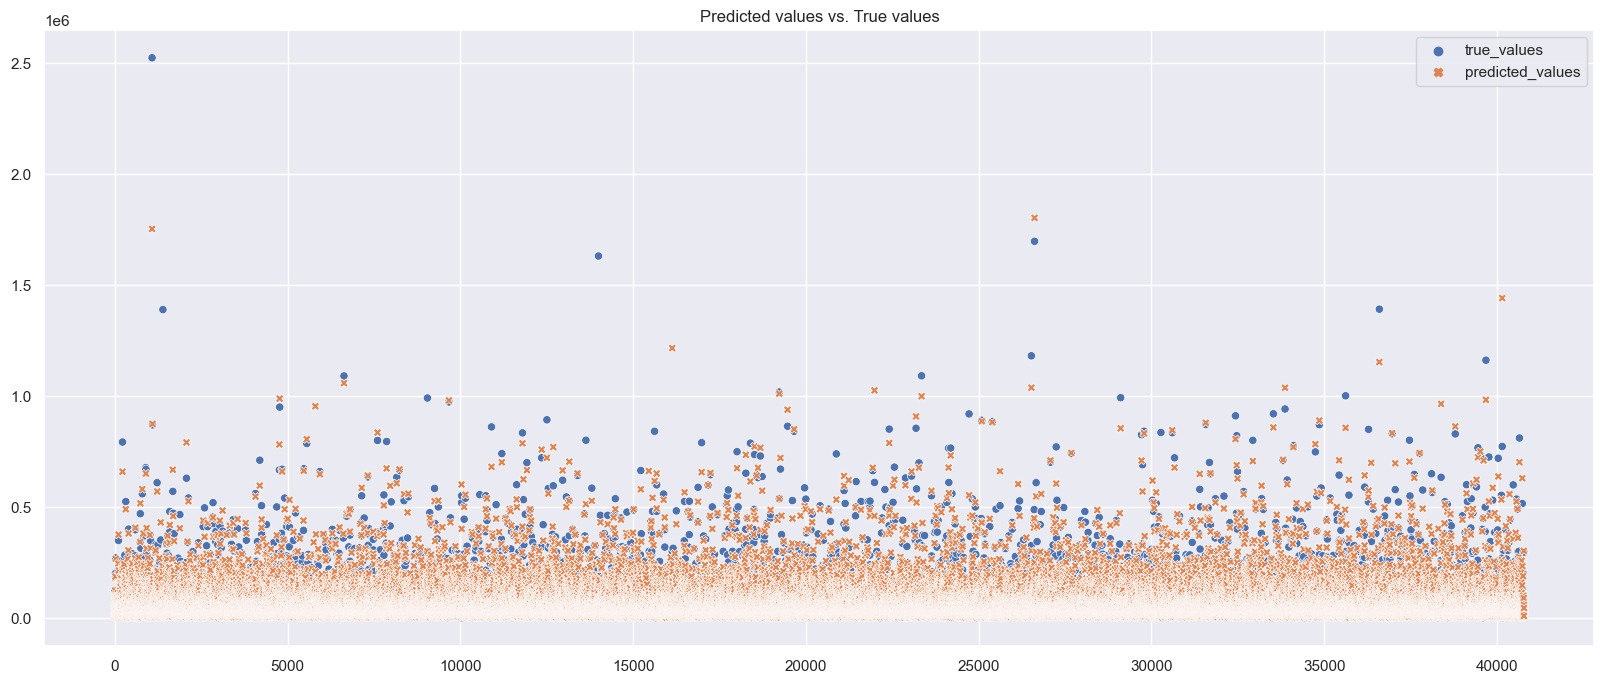

In [75]:
plot_compare_true_pred(y_test, y_pred)

### Summary

The best regression model had a MAE of 7491.34 PLN, RMSE of 22588.97 PLN and R2 of 92%. The errors are caused by poorer precision of prediction for expensive cars. Further, actions listed below would result in better model performance.

#### Further actions

1. Definitely try out other regression models e.g. ridge regressor or SVM regressor.
2. Spend more time on the reliability of the dataset - try out other methods of filling NaNs, find and drop more outliers, that I might have missed.
3. Spend more time on visualization, it may help me with better understanding the problem.
4. Plot more information about model performance.


Thank you for reading this notebook,
Piotr Baryczkowski